FOURIER-WEINER TRANSFORM TRESHOLDING PRINCIPLE

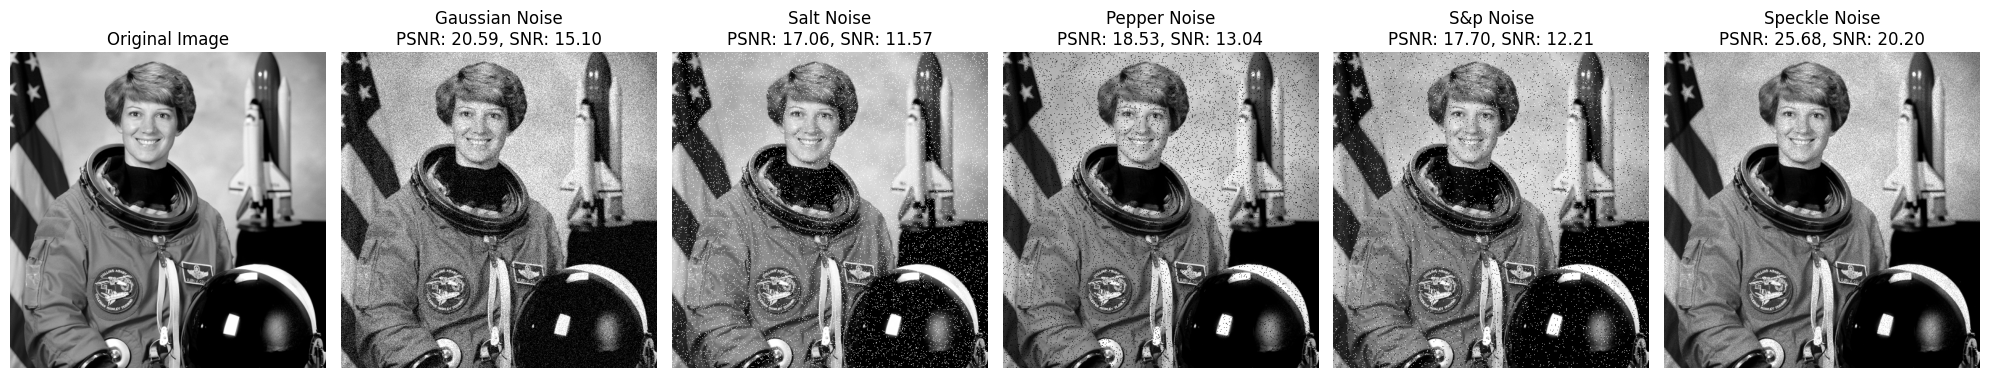

In [42]:
import os
import matplotlib.pyplot as plt
import numpy as np
from skimage import data, io, color, img_as_ubyte
from skimage.util import random_noise
from skimage.metrics import peak_signal_noise_ratio as psnr


folder_name = "images"
os.makedirs(folder_name, exist_ok=True)

image = data.astronaut()
image_gray = color.rgb2gray(image)
image_path = os.path.join(folder_name, "lena_gray.png")
io.imsave(image_path, img_as_ubyte(image_gray))

noises = ["gaussian", "salt", "pepper", "s&p", "speckle"]
noisy_images = {}

for noise_type in noises:
    noisy_img = random_noise(image_gray, mode=noise_type)
    noisy_img_path = os.path.join(folder_name, f"lena_{noise_type}.png")
    io.imsave(noisy_img_path, img_as_ubyte(noisy_img))
    noisy_images[noise_type] = noisy_img

fig, axes = plt.subplots(1, len(noisy_images) + 1, figsize=(20, 5))
axes[0].imshow(image_gray, cmap="gray")
axes[0].set_title("Original Image")
axes[0].axis("off")

for i, (noise_type, noisy_img) in enumerate(noisy_images.items(), start=1):
    psnr_value = psnr(image_gray, noisy_img)
    snr_value = 10 * np.log10(np.mean(image_gray ** 2) / np.mean((image_gray - noisy_img) ** 2))
    axes[i].imshow(noisy_img, cmap="gray")
    axes[i].set_title(f"{noise_type.capitalize()} Noise\nPSNR: {psnr_value:.2f}, SNR: {snr_value:.2f}")
    axes[i].axis("off")

plt.tight_layout()
plt.show()


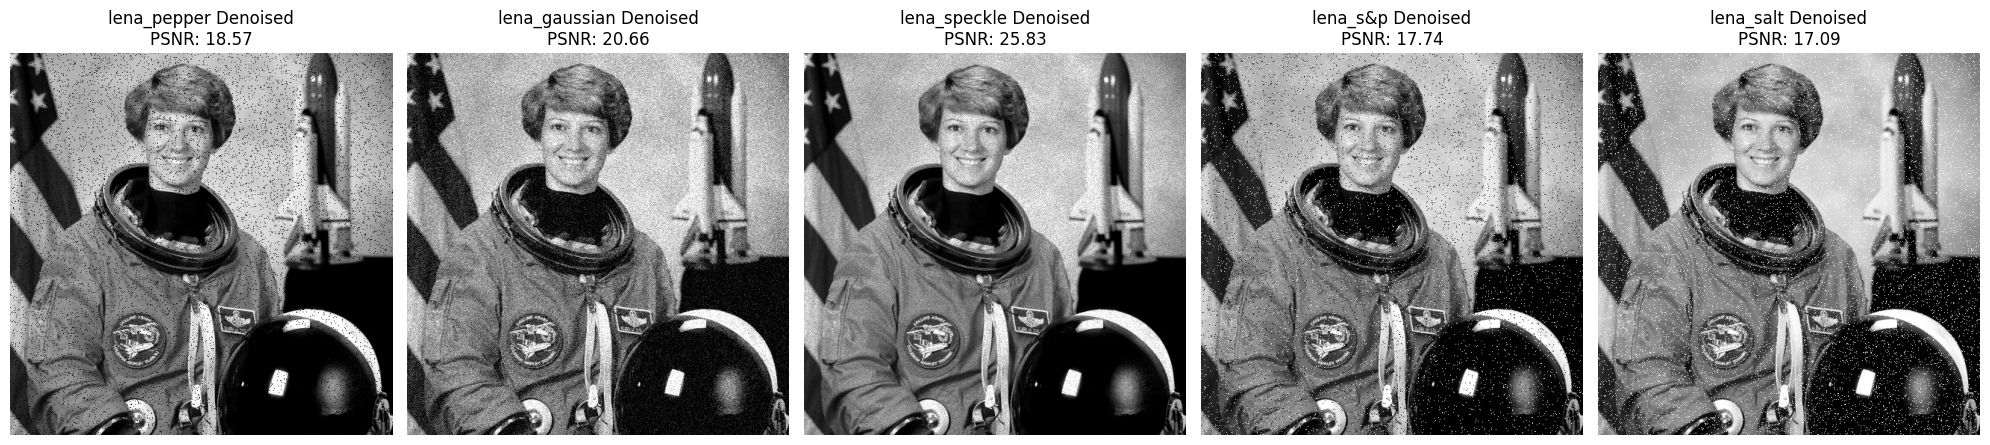

In [43]:
import os
import numpy as np
import matplotlib.pyplot as plt
from skimage import io, img_as_ubyte
from skimage.metrics import peak_signal_noise_ratio as psnr
from scipy.fft import fft2, ifft2

folder_name = "images"
out_folder = "FFT_W"
os.makedirs(out_folder, exist_ok=True)

def estimate_sigma(image):
    return np.std(image - np.mean(image))

def fourier_weiner_denoising(image, sigma, iterations=20, block_size=32):
    h, w = image.shape
    denoised_image = np.zeros_like(image)
    weight_matrix = np.zeros_like(image)

    for i in range(0, h, block_size):
        for j in range(0, w, block_size):
            block = image[i:i + block_size, j:j + block_size]
            fft_block = fft2(block)
            magnitude = np.abs(fft_block)
            phase = np.angle(fft_block)

            # Adaptive Wiener filter
            a = magnitude**2 / (magnitude**2 + sigma**2)
            denoised_fft_block = a * fft_block
            denoised_block = np.real(ifft2(denoised_fft_block))

            denoised_image[i:i + block_size, j:j + block_size] += denoised_block
            weight_matrix[i:i + block_size, j:j + block_size] += 1

    denoised_image /= weight_matrix
    denoised_image = np.clip(denoised_image, 0, 1)
    return denoised_image

original_image_path = os.path.join(folder_name, "lena_gray.png")
original_image = io.imread(original_image_path) / 255.0

noisy_images = [file for file in os.listdir(folder_name) if file != "lena_gray.png" and file.endswith(".png")]

denoised_images = {}

for noisy_image_file in noisy_images:
    noisy_image_path = os.path.join(folder_name, noisy_image_file)
    noisy_image = io.imread(noisy_image_path) / 255.0

    estimated_sigma = estimate_sigma(noisy_image)
    denoised_image = fourier_weiner_denoising(noisy_image, estimated_sigma, iterations=5, block_size=32)

    denoised_image = np.clip(denoised_image, 0, 1)
    denoised_file_name = noisy_image_file.replace(".png", "_denoise.png")
    denoised_image_path = os.path.join(out_folder, denoised_file_name)
    io.imsave(denoised_image_path, img_as_ubyte(denoised_image))

    denoised_images[noisy_image_file] = denoised_image

fig, axes = plt.subplots(1, len(denoised_images), figsize=(20, 5))

for ax, (noisy_image_file, denoised_image) in zip(axes, denoised_images.items()):
    psnr_value = psnr(original_image, denoised_image)
    ax.imshow(denoised_image, cmap="gray")
    title = noisy_image_file.replace(".png", " Denoised")
    ax.set_title(f"{title}\nPSNR: {psnr_value:.2f}")
    ax.axis("off")

plt.tight_layout()
plt.show()


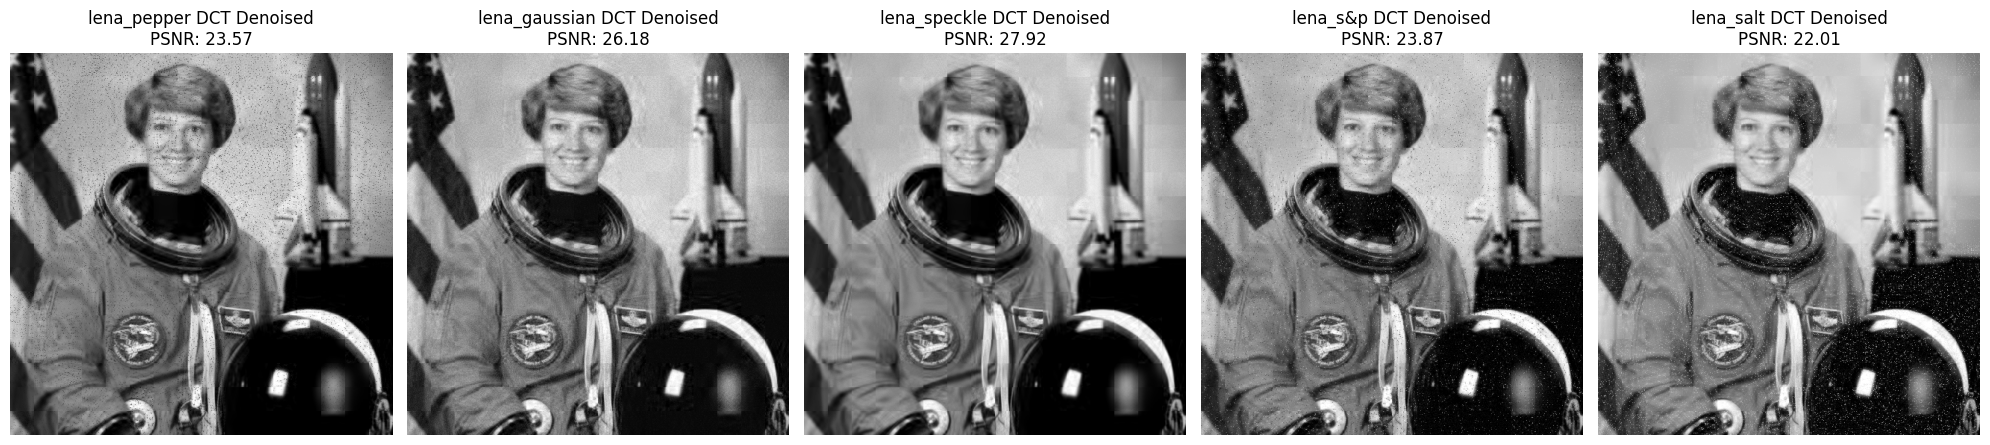

In [44]:
import os
import numpy as np
import matplotlib.pyplot as plt
from skimage import io, img_as_ubyte
from skimage.metrics import peak_signal_noise_ratio as psnr
from scipy.fftpack import dct, idct

folder_name = "images"
out_folder = "DCT_W"
os.makedirs(out_folder, exist_ok=True)

def estimate_sigma(image):
    return np.std(image - np.mean(image))

def dct_weiner_denoising(image, sigma, iterations=3, block_size=32):
    h, w = image.shape
    denoised_image = np.zeros_like(image)
    weight_matrix = np.zeros_like(image)

    for i in range(0, h, block_size):
        for j in range(0, w, block_size):
            block = image[i:i + block_size, j:j + block_size]
            dct_block = dct(dct(block.T, norm='ortho').T, norm='ortho')
            magnitude = np.abs(dct_block)

            # Adaptive Wiener filter
            a = magnitude**2 / (magnitude**2 + sigma**2)
            denoised_dct_block = a * dct_block
            denoised_block = idct(idct(denoised_dct_block.T, norm='ortho').T, norm='ortho')

            denoised_image[i:i + block_size, j:j + block_size] += denoised_block
            weight_matrix[i:i + block_size, j:j + block_size] += 1

    denoised_image /= weight_matrix
    denoised_image = np.clip(denoised_image, 0, 1)
    return denoised_image

original_image_path = os.path.join(folder_name, "lena_gray.png")
original_image = io.imread(original_image_path) / 255.0

noisy_images = [file for file in os.listdir(folder_name) if file != "lena_gray.png" and file.endswith(".png")]

denoised_images = {}

for noisy_image_file in noisy_images:
    noisy_image_path = os.path.join(folder_name, noisy_image_file)
    noisy_image = io.imread(noisy_image_path) / 255.0

    estimated_sigma = estimate_sigma(noisy_image)
    denoised_image = dct_weiner_denoising(noisy_image, estimated_sigma, iterations=5, block_size=32)

    denoised_image = np.clip(denoised_image, 0, 1)
    denoised_file_name = noisy_image_file.replace(".png", "_dct_denoise.png")
    denoised_image_path = os.path.join(out_folder, denoised_file_name)
    io.imsave(denoised_image_path, img_as_ubyte(denoised_image))

    denoised_images[noisy_image_file] = denoised_image

fig, axes = plt.subplots(1, len(denoised_images), figsize=(20, 5))

for ax, (noisy_image_file, denoised_image) in zip(axes, denoised_images.items()):
    denoised_file_name = noisy_image_file.replace(".png", "_dct_denoise.png")
    denoised_image_path = os.path.join(out_folder, denoised_file_name)

    denoised_image = io.imread(denoised_image_path) / 255.0

    psnr_value = psnr(original_image, denoised_image)
    ax.imshow(denoised_image, cmap="gray")
    title = noisy_image_file.replace(".png", " DCT Denoised")
    ax.set_title(f"{title}\nPSNR: {psnr_value:.2f}")
    ax.axis("off")

plt.tight_layout()
plt.show()

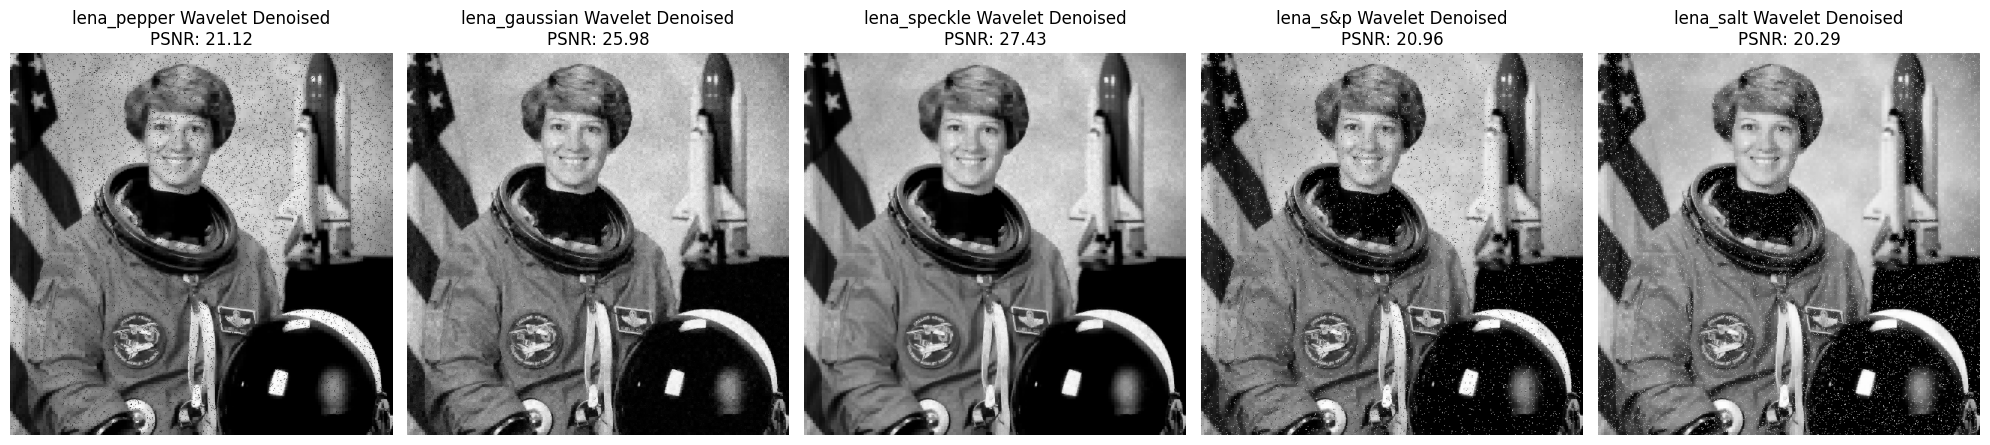

In [45]:
import os
import numpy as np
import matplotlib.pyplot as plt
from skimage import io, img_as_ubyte
from skimage.metrics import peak_signal_noise_ratio as psnr
import pywt

folder_name = "images"
out_folder = "Wavelet_W"
os.makedirs(out_folder, exist_ok=True)

def estimate_sigma(image):
    return np.std(image - np.mean(image))

def wavelet_weiner_denoising(image, sigma, wavelet='db1', level=2):
    coeffs = pywt.wavedec2(image, wavelet=wavelet, level=level)
    denoised_coeffs = []

    for coeff in coeffs:
        if isinstance(coeff, tuple):
            cH, cV, cD = coeff
            cH = cH * (cH**2 / (cH**2 + sigma**2))
            cV = cV * (cV**2 / (cV**2 + sigma**2))
            cD = cD * (cD**2 / (cD**2 + sigma**2))
            denoised_coeffs.append((cH, cV, cD))
        else:
            coeff = coeff * (coeff**2 / (coeff**2 + sigma**2))
            denoised_coeffs.append(coeff)

    denoised_image = pywt.waverec2(denoised_coeffs, wavelet=wavelet)
    denoised_image = np.clip(denoised_image, 0, 1)
    return denoised_image

original_image_path = os.path.join(folder_name, "lena_gray.png")
original_image = io.imread(original_image_path) / 255.0

noisy_images = [file for file in os.listdir(folder_name) if file != "lena_gray.png" and file.endswith(".png")]

denoised_images = {}

for noisy_image_file in noisy_images:
    noisy_image_path = os.path.join(folder_name, noisy_image_file)
    noisy_image = io.imread(noisy_image_path) / 255.0

    estimated_sigma = estimate_sigma(noisy_image)
    denoised_image = wavelet_weiner_denoising(noisy_image, estimated_sigma, wavelet='db1', level=2)

    denoised_image = np.clip(denoised_image, 0, 1)
    denoised_file_name = noisy_image_file.replace(".png", "_wavelet_denoise.png")
    denoised_image_path = os.path.join(out_folder, denoised_file_name)
    io.imsave(denoised_image_path, img_as_ubyte(denoised_image))

    denoised_images[noisy_image_file] = denoised_image

fig, axes = plt.subplots(1, len(denoised_images), figsize=(20, 5))

for ax, (noisy_image_file, denoised_image) in zip(axes, denoised_images.items()):
    denoised_file_name = noisy_image_file.replace(".png", "_wavelet_denoise.png")
    denoised_image_path = os.path.join(out_folder, denoised_file_name)

    denoised_image = io.imread(denoised_image_path) / 255.0

    psnr_value = psnr(original_image, denoised_image)
    ax.imshow(denoised_image, cmap="gray")
    title = noisy_image_file.replace(".png", " Wavelet Denoised")
    ax.set_title(f"{title}\nPSNR: {psnr_value:.2f}")
    ax.axis("off")

plt.tight_layout()
plt.show()


Analyzing results for Fourier method...


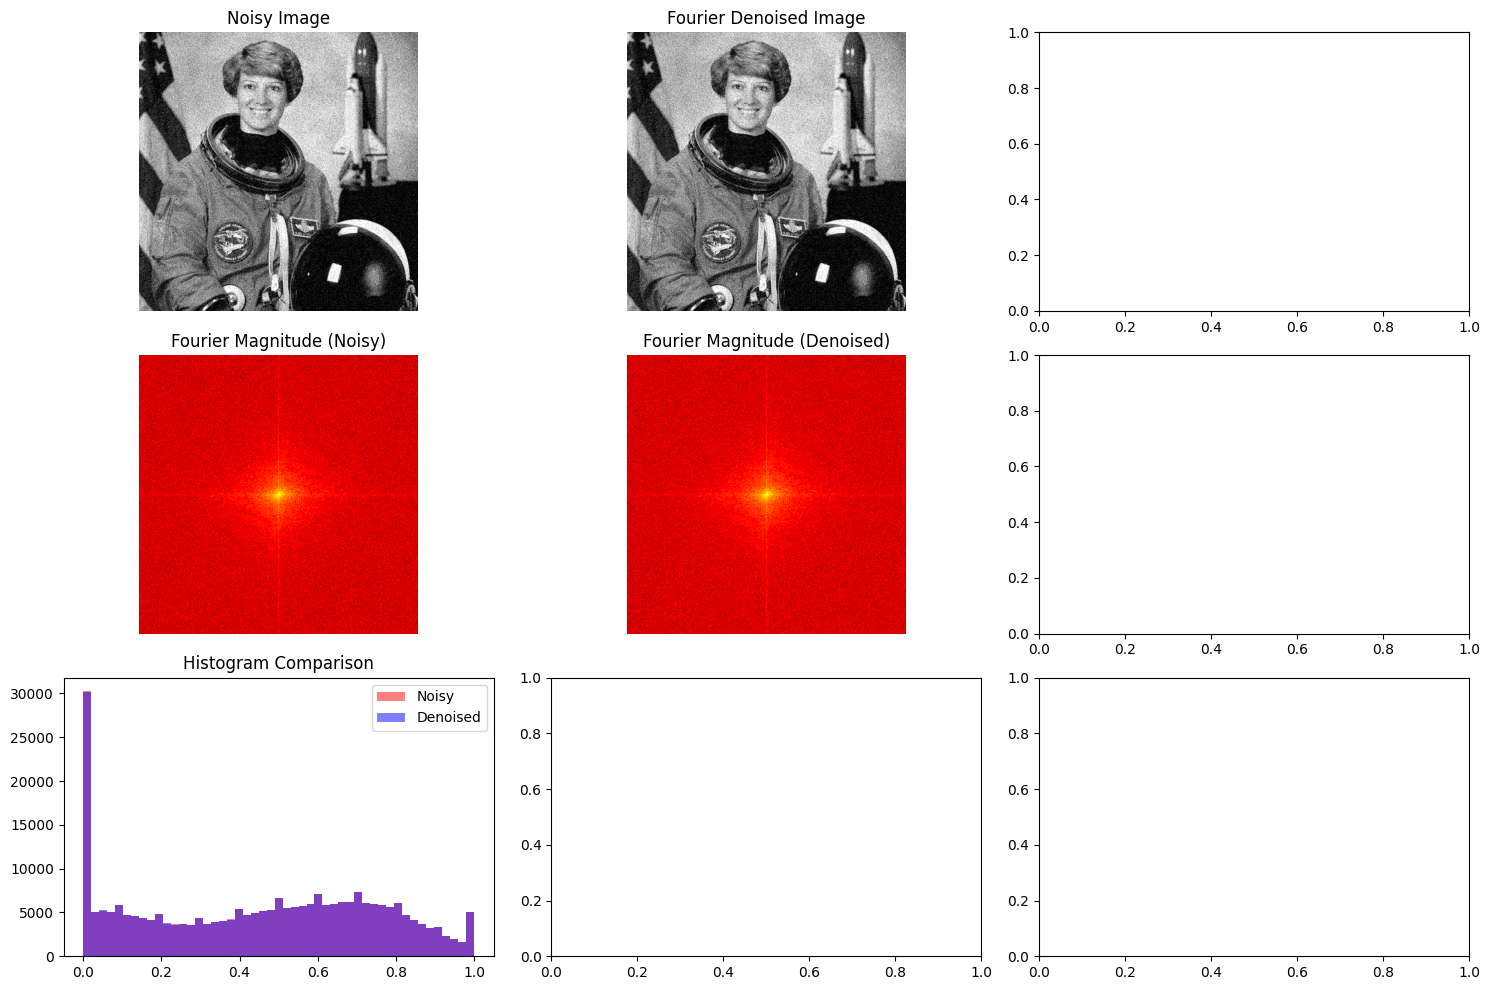

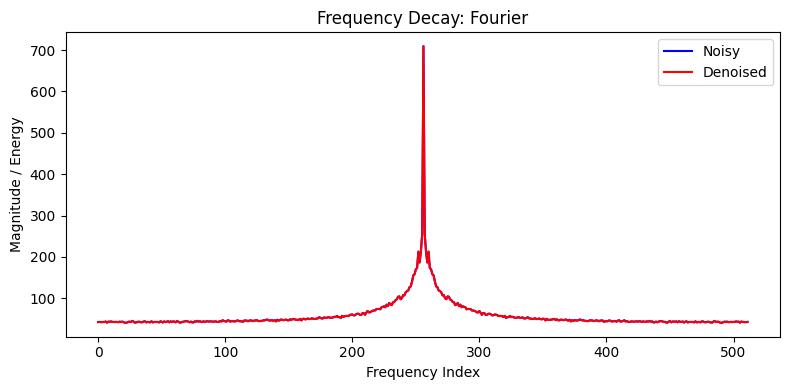

Analyzing results for DCT method...


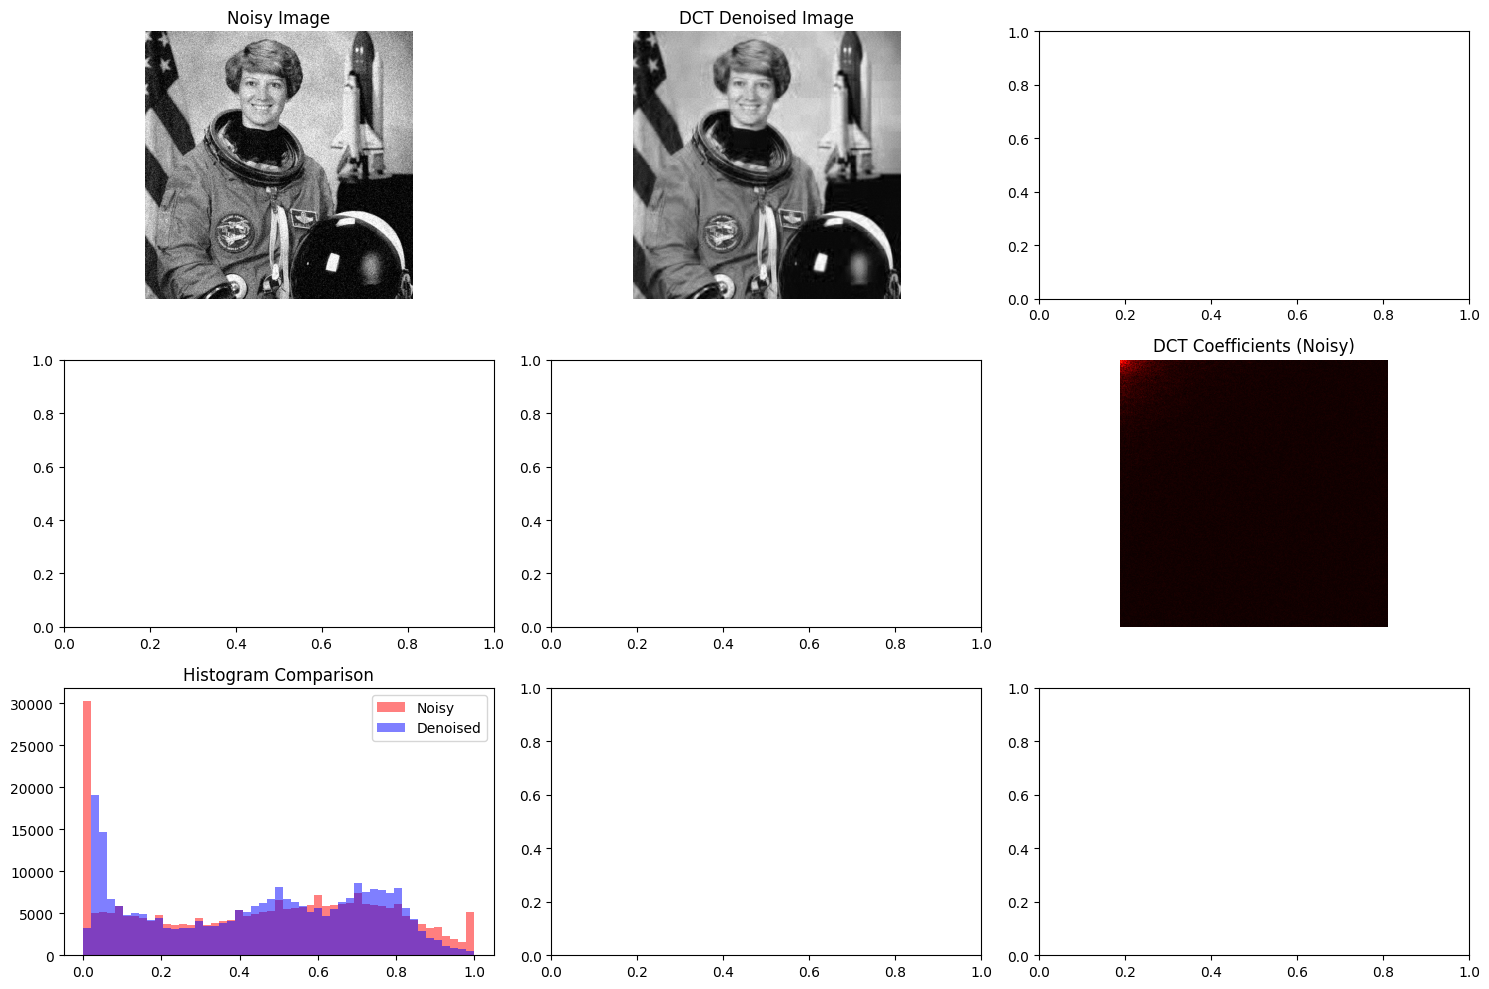

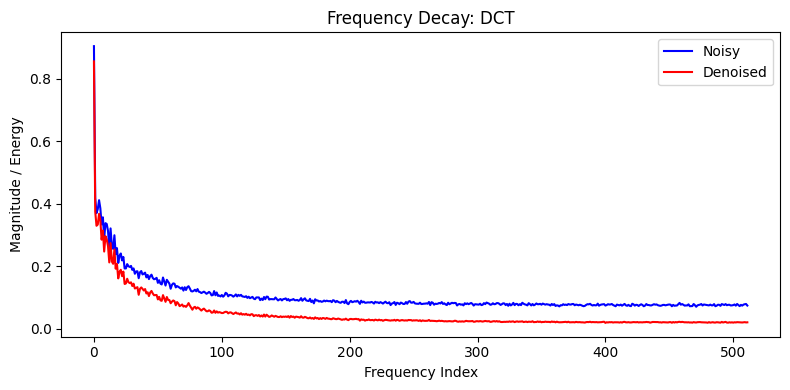

Analyzing results for Wavelet method...


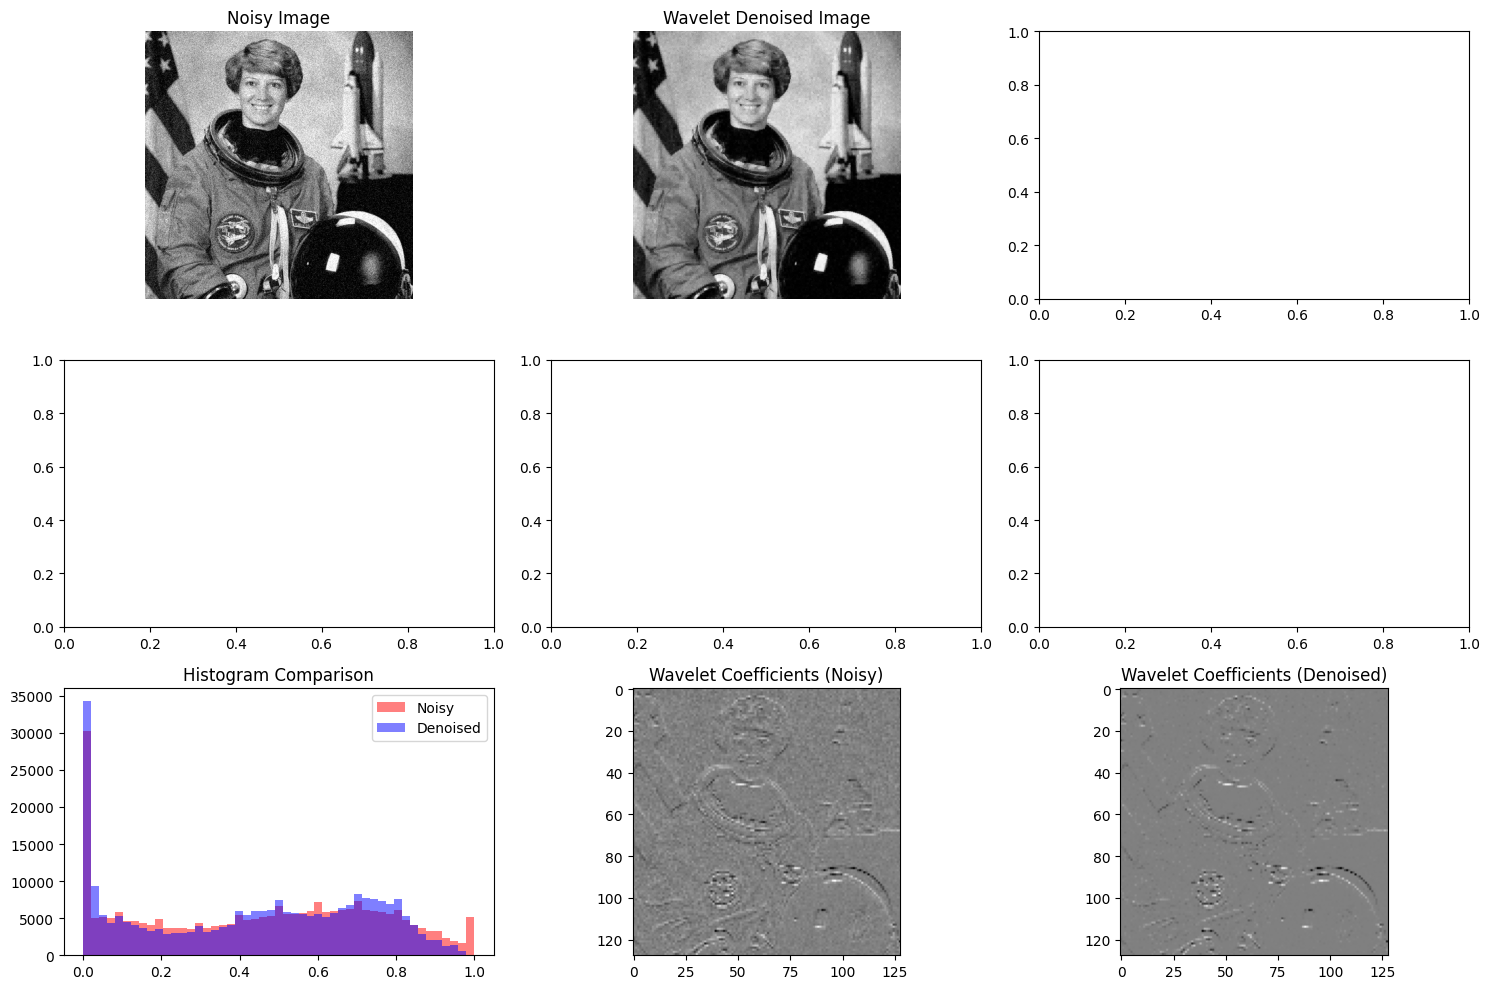

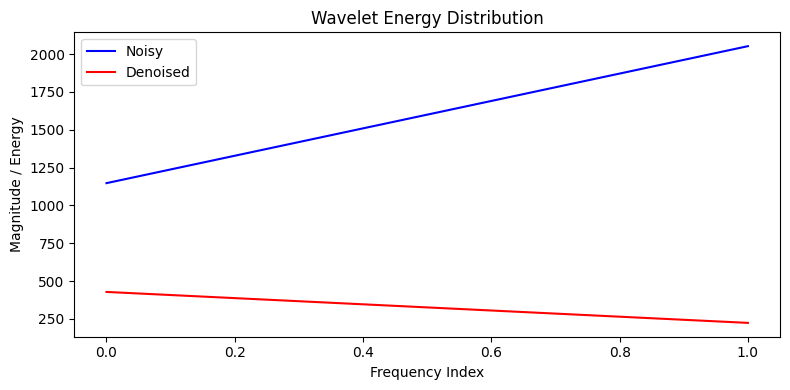

In [48]:
import os
import numpy as np
import matplotlib.pyplot as plt
from scipy.fftpack import fft2, fftshift, dct
import pywt
from skimage import io

# Define folders
folder_name = "images"
out_folders = {
    "Fourier": "FFT_W",
    "DCT": "DCT_W",
    "Wavelet": "Wavelet_W"
}

# Iterate through methods and analyze images
for method, out_folder in out_folders.items():
    print(f"Analyzing results for {method} method...")

    # Select a sample noisy and denoised image
    noisy_image_file = "lena_gaussian.png"  # Replace with the actual noisy image name
    if method == "Fourier":
        denoised_image_file = "lena_gaussian_denoise.png"
    elif method == "DCT":
        denoised_image_file = "lena_gaussian_dct_denoise.png"
    elif method == "Wavelet":
        denoised_image_file = "lena_gaussian_wavelet_denoise.png"

    noisy_image_path = os.path.join(folder_name, noisy_image_file)
    denoised_image_path = os.path.join(out_folder, denoised_image_file)

    noisy_image = io.imread(noisy_image_path) / 255.0
    denoised_image = io.imread(denoised_image_path) / 255.0

    # Fourier analysis
    fft_noisy = fft2(noisy_image)
    fft_noisy_magnitude = np.log(np.abs(fftshift(fft_noisy)) + 1)

    fft_denoised = fft2(denoised_image)
    fft_denoised_magnitude = np.log(np.abs(fftshift(fft_denoised)) + 1)

    # DCT analysis
    dct_noisy = dct(dct(noisy_image.T, norm='ortho').T, norm='ortho')
    dct_denoised = dct(dct(denoised_image.T, norm='ortho').T, norm='ortho')

    # Wavelet analysis
    wavelet = 'db1'
    coeffs_noisy = pywt.wavedec2(noisy_image, wavelet=wavelet, level=2)
    coeffs_denoised = pywt.wavedec2(denoised_image, wavelet=wavelet, level=2)

    # Histogram comparison
    bins = np.linspace(0, 1, 50)

    # Plot the results
    fig, axes = plt.subplots(3, 3, figsize=(15, 10))

    # Original and denoised images
    axes[0, 0].imshow(noisy_image, cmap='gray')
    axes[0, 0].set_title("Noisy Image")
    axes[0, 0].axis("off")

    axes[0, 1].imshow(denoised_image, cmap='gray')
    axes[0, 1].set_title(f"{method} Denoised Image")
    axes[0, 1].axis("off")

    # Fourier magnitudes
    if method == "Fourier":
        axes[1, 0].imshow(fft_noisy_magnitude, cmap='hot')
        axes[1, 0].set_title("Fourier Magnitude (Noisy)")
        axes[1, 0].axis("off")

        axes[1, 1].imshow(fft_denoised_magnitude, cmap='hot')
        axes[1, 1].set_title("Fourier Magnitude (Denoised)")
        axes[1, 1].axis("off")

    # DCT visualization
    if method == "DCT":
        axes[1, 2].imshow(np.log(np.abs(dct_noisy) + 1), cmap='hot')
        axes[1, 2].set_title("DCT Coefficients (Noisy)")
        axes[1, 2].axis("off")

    # Histogram comparison
    axes[2, 0].hist(noisy_image.ravel(), bins=bins, alpha=0.5, label="Noisy", color="red")
    axes[2, 0].hist(denoised_image.ravel(), bins=bins, alpha=0.5, label="Denoised", color="blue")
    axes[2, 0].set_title("Histogram Comparison")
    axes[2, 0].legend()

    # Wavelet detail coefficients
    if method == "Wavelet":
        cH, cV, cD = coeffs_noisy[1]
        axes[2, 1].imshow(cH, cmap='gray')
        axes[2, 1].set_title("Wavelet Coefficients (Noisy)")

        cH_d, cV_d, cD_d = coeffs_denoised[1]
        axes[2, 2].imshow(cH_d, cmap='gray')
        axes[2, 2].set_title("Wavelet Coefficients (Denoised)")

    plt.tight_layout()
    plt.show()

# Additional plot: Comparison of smoothness and frequency decay
    fig, ax = plt.subplots(1, 1, figsize=(8, 4))

    if method == "Fourier":
        ax.plot(np.abs(fftshift(fft_noisy)).mean(axis=0), label="Noisy", color="blue")
        ax.plot(np.abs(fftshift(fft_denoised)).mean(axis=0), label="Denoised", color="red")
        ax.set_title("Frequency Decay: Fourier")

    elif method == "DCT":
        ax.plot(np.abs(dct_noisy).mean(axis=0), label="Noisy", color="blue")
        ax.plot(np.abs(dct_denoised).mean(axis=0), label="Denoised", color="red")
        ax.set_title("Frequency Decay: DCT")

    elif method == "Wavelet":
        noisy_energy = [np.sum(np.abs(coeff)**2) for coeff in coeffs_noisy if isinstance(coeff, tuple)]
        denoised_energy = [np.sum(np.abs(coeff)**2) for coeff in coeffs_denoised if isinstance(coeff, tuple)]
        ax.plot(noisy_energy, label="Noisy", color="blue")
        ax.plot(denoised_energy, label="Denoised", color="red")
        ax.set_title("Wavelet Energy Distribution")

    ax.legend()
    ax.set_xlabel("Frequency Index")
    ax.set_ylabel("Magnitude / Energy")
    plt.tight_layout()
    plt.show()


SELF SIMILARITY PRINCIPLE AND PATCH BASED METHODS